### CNN for Butterfly species DPL301m

In [31]:
from torchvision.models import EfficientNet_B3_Weights, ConvNeXt_Base_Weights

In [25]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from albumentations.pytorch import ToTensorV2
import albumentations as A
import cv2
import os

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
IMAGE_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 25
PATIENCE = 7
LEARNING_RATE = 5e-5

In [ ]:
csv_path = 'Training_set.csv'
image_folder = 'buom_img/train/train'
df = pd.read_csv(csv_path)
label2idx = {label: i for i, label in enumerate(sorted(df['label'].unique()))}
df['label'] = df['label'].map(label2idx)
NUM_CLASSES = len(label2idx)

train_df, val_df = train_test_split(df, test_size=0.05, stratify=df['label'], random_state=42)

train_transform = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=10, val_shift_limit=5, p=0.1),
    A.Affine(scale=(0.95, 1.05), rotate=(-5, 5), translate_percent=(0.02, 0.02), p=0.1),
    A.Normalize(
    mean=(0.485, 0.456, 0.406),
    std=(0.229, 0.224, 0.225),
    max_pixel_value=255.0
),

    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.Normalize(
    mean=(0.485, 0.456, 0.406),
    std=(0.229, 0.224, 0.225),
    max_pixel_value=255.0
),

    ToTensorV2(),
])

class CustomDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform):
        self.df = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = cv2.imread(os.path.join(self.image_dir, row['filename']))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transform(image=image)['image']
        label = row['label']
        return image, label

train_dataset = CustomDataset(train_df, image_folder, train_transform)
val_dataset = CustomDataset(val_df, image_folder, val_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)


# REVIEW DATA

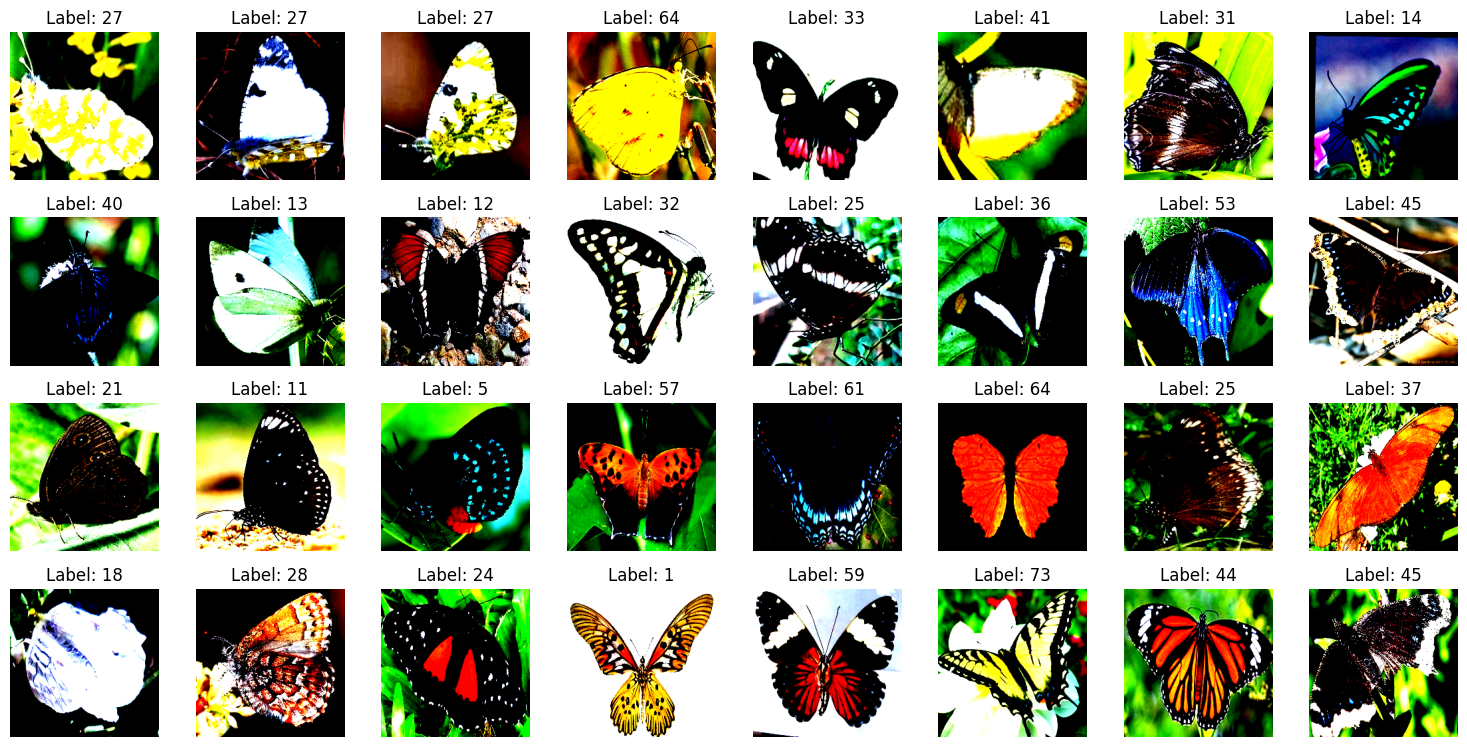

In [ ]:
import matplotlib.pyplot as plt

def show_normalized_images(images, labels, n_cols=8):
    n_images = min(len(images), n_cols**2)
    plt.figure(figsize=(15, 15))
    for i in range(n_images):
        img = images[i].permute(1, 2, 0).cpu().numpy() 
        plt.subplot(n_cols, n_cols, i + 1)
        plt.imshow(img)  
        plt.title(f"Label: {labels[i].item()}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Hiển thị 1 batch
images, labels = next(iter(train_loader))
show_normalized_images(images, labels)


In [ ]:
# Hiển thị số ảnh và số lớp trong một batch
images, labels = next(iter(train_loader))

print("Kích thước ảnh (batch_size, C, H, W):", images.shape)
print("Nhãn:", labels)
print("Số ảnh trong batch:", images.shape[0])
print("Số lớp khác nhau trong batch:", len(set(labels.tolist())))


Kích thước ảnh (batch_size, C, H, W): torch.Size([32, 3, 224, 224])
Nhãn: tensor([44, 51, 22,  6, 46, 56, 71, 32, 70, 29, 38, 65, 34, 46, 35,  6,  6, 59,
        58, 22,  9, 19, 31, 42, 34, 52, 49, 16, 18, 67, 73,  8])
Số ảnh trong batch: 32
Số lớp khác nhau trong batch: 27


# MODEL

In [ ]:
class EnsembleModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model1 = models.efficientnet_b3(weights=EfficientNet_B3_Weights.DEFAULT)
        self.model2 = models.convnext_base(weights=ConvNeXt_Base_Weights.DEFAULT)
        
        self.model1.classifier = nn.Identity()
        self.model2.classifier = nn.Identity()
        
        self.classifier = nn.Sequential(
            nn.Linear(1536 + 1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        f1 = self.model1(x)
        f2 = self.model2(x)
    
        if f1.ndim > 2:
            f1 = torch.flatten(f1, 1)
        if f2.ndim > 2:
            f2 = torch.flatten(f2, 1)
            
        features = torch.cat((f1, f2), dim=1)
        out = self.classifier(features)
        return out

model = EnsembleModel(NUM_CLASSES).to(DEVICE)


Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 223MB/s]
Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to /root/.cache/torch/hub/checkpoints/convnext_base-6075fbad.pth
100%|██████████| 338M/338M [00:01<00:00, 225MB/s] 


In [ ]:
# LOSS
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes

    def forward(self, x, target):
        pred = x.log_softmax(dim=-1)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=-1))

criterion = LabelSmoothingLoss(NUM_CLASSES, smoothing=0.1)

In [ ]:
# Công tắc freeze/unfreeze
def set_requires_grad(model, requires_grad=True):
    for param in model.parameters():
        param.requires_grad = requires_grad

In [ ]:
def train(model, train_loader, val_loader, num_epochs=25):
    best_acc = 0

    print("Phase 1: Freeze backbones (Epoch 1–4)")
    set_requires_grad(model.model1, False)
    set_requires_grad(model.model2, False)

    optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)

    for epoch in range(1, 5):
        model.train()
        total_loss, correct = 0, 0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

        train_acc = correct / len(train_loader.dataset)

        model.eval()
        val_correct = 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
                outputs = model(imgs)
                val_correct += (outputs.argmax(1) == labels).sum().item()
        val_acc = val_correct / len(val_loader.dataset)

        print(f"Epoch {epoch:02d} [Frozen] / {EPOCHS} | Loss: {total_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
    
    print(f"Epoch {epoch} completed successfully.\n")

    # =======================================================
    print("\nPhase 2: Fine-tune entire model (Epoch 5–25)")
    set_requires_grad(model.model1, True)
    set_requires_grad(model.model2, True)

    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

    for epoch in range(5, num_epochs + 1):
        model.train()
        total_loss, correct = 0, 0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

        train_acc = correct / len(train_loader.dataset)

        model.eval()
        val_correct = 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
                outputs = model(imgs)
                val_correct += (outputs.argmax(1) == labels).sum().item()
        val_acc = val_correct / len(val_loader.dataset)

        print(f"Epoch {epoch:02d} [Fine-tune] / {EPOCHS} | Loss: {total_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
    
        if val_acc > best_acc:
            best_acc = val_acc
            counter = 0
            if best_acc > 0.95:
                torch.save(model.state_dict(), "best_model.pth")
        else:
            counter += 1
            if counter >= PATIENCE:
                print("Early stopping triggered")
                break
    print(f"✅ Epoch {epoch} completed successfully.\n")


In [11]:
train(model, train_loader, val_loader, EPOCHS)

🔒 Phase 1: Freeze backbones (Epoch 1–4)
Epoch 01 [Frozen] / 25 | Loss: 639.8073 | Train Acc: 0.0316 | Val Acc: 0.0920
Epoch 02 [Frozen] / 25 | Loss: 630.4031 | Train Acc: 0.1141 | Val Acc: 0.2400
Epoch 03 [Frozen] / 25 | Loss: 619.1861 | Train Acc: 0.1935 | Val Acc: 0.2920
Epoch 04 [Frozen] / 25 | Loss: 605.7265 | Train Acc: 0.2579 | Val Acc: 0.3320
✅ Epoch 4 completed successfully.


🔥 Phase 2: Fine-tune entire model (Epoch 5–25)
Epoch 05 [Fine-tune] / 25 | Loss: 400.3205 | Train Acc: 0.4667 | Val Acc: 0.7880
Epoch 06 [Fine-tune] / 25 | Loss: 217.3844 | Train Acc: 0.8223 | Val Acc: 0.9320
Epoch 07 [Fine-tune] / 25 | Loss: 171.3378 | Train Acc: 0.9187 | Val Acc: 0.9160
Epoch 08 [Fine-tune] / 25 | Loss: 154.5489 | Train Acc: 0.9547 | Val Acc: 0.9440
Epoch 09 [Fine-tune] / 25 | Loss: 143.5900 | Train Acc: 0.9735 | Val Acc: 0.9440
Epoch 10 [Fine-tune] / 25 | Loss: 137.6855 | Train Acc: 0.9796 | Val Acc: 0.9520
Epoch 11 [Fine-tune] / 25 | Loss: 133.4295 | Train Acc: 0.9857 | Val Acc: 0.948

# TEST

In [ ]:
# TEST
TEST_DIR = "buom_img/test/test"

idx2label = {v: k for k, v in label2idx.items()}
idx2label = {int(k): v for k, v in idx2label.items()}


test_transform = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.Normalize(
    mean=(0.485, 0.456, 0.406),
    std=(0.229, 0.224, 0.225),
    max_pixel_value=255.0
),
    ToTensorV2(),
])

model.eval()

# Sử dụng gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

#====================#
results = []

with torch.no_grad():
    for img_name in sorted(os.listdir(TEST_DIR)):
        img_path = os.path.join(TEST_DIR, img_name)

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        transformed = test_transform(image=image)
        image_tensor = transformed['image'].unsqueeze(0).to(device)  

        output = model(image_tensor)
        pred_idx = output.argmax(dim=1).item()
        pred_label = idx2label[pred_idx]

        results.append({
            "ID": img_name,
            "label": pred_label
        })

df_test = pd.DataFrame(results)
df_test.head()

,ID,label
0,Image_1.jpg,SCARCE SWALLOW
1,Image_10.jpg,STRAITED QUEEN
2,Image_100.jpg,ULYSES
3,Image_1000.jpg,INDRA SWALLOW
4,Image_1001.jpg,MONARCH


In [ ]:
result = "hybid40_fre.csv"
df_test.to_csv(result, index=False)
print(f"Đã xuất kết quả test vào: {result}")